In [1]:
import rebound
import reboundx
import numpy as np

We start by loading a SimulationArchive, which is a set of binary snapshots of a simulation.

Check out https://github.com/hannorein/rebound/blob/master/ipython_examples/SimulationArchive.ipynb and https://github.com/hannorein/rebound/blob/master/ipython_examples/SimulationArchiveRestart.ipynb for more on simulation archives.

I've added one particular simulation to the repo. You can get additional initial conditions at https://zenodo.org/record/496153

In [2]:
sa = rebound.SimulationArchive('IC100K1.2213e+02mag6.8408e-03.bin')

/mnt/raid-cita/dtamayo/rebound/rebound/simulationarchive.py:63: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(BINARY_WARNINGS[1][0], RuntimeWarning)


We get the initial conditions by taking the first element in the simulationarchive list. We then add REBOUNDx, and add eccentricity damping for a synchronous satellite/planet

In [76]:
sim = sa[0]
rebx = reboundx.Extras(sim)
damping = rebx.add("tides_synchronous_ecc_damping")
damping.force_as_operator = 1
damping.operator_order = 1

The units in the simulation are AUs, years and solar masses. So that applies to all the distances, times and masses you get or put into the simulation. For example the orbital period of the innermost planet is. Note that these won't correspond exactly to what's in the paper. That's because I migrated the planets into the resonant chain with different parameters, which determine how deep into the resonances they get, i.e., how close their period ratios get to the nominal ones, e.g. 1.5 for 3:2 resonance. Over time, with the dissipation, the period ratios will increase, and if we wanted to we could try to tune it so they reach the observed ones...not sure what the easiest way to do that is though, since it's nonlinear.

In [77]:
ps = sim.particles
ps[1].P

0.004154133349427933

Each planet can now be assigned an eccentricity-damping timescale. It's up to you to calculate it. The implementation is based on the simple constant equilibrium time-lag model of Hut (1981), in particular the second term in the square brackets in Eq. 6 (the first is the conservative precession induced by the tidal bulge, implemented in the "tides_precession" effect, see https://github.com/dtamayo/reboundx/blob/master/ipython_examples/TidesPrecession.ipynb). So you would have to calculate the Ps in Eq. 5, or you could also calculate the equivalent eccentricity damping timescale for a constant phase lag model--I think it leads to the same term in the equation of motion Eq 6.

Planets are assigned their own tau_e individually. Here I just add an eccentricity damping timescale onto the 3rd planet (first one in a 1st-order resonance, the inner two have very low eccentricities). Timescale should be negative, otherwise you'll get eccentricity growth!

In [78]:
ps[3].params["tides_synchronous_tau_e"] = -1.e4

We now run a short simulation and keep track of the innermost planet's eccentricity. You could do anything you want at this point. The best starting point to learn REBOUND is the examples: https://github.com/hannorein/rebound/tree/master/ipython_examples. Try to find something that sounds like what you want to do. Of course feel free to ask me too and I can point you to the right place or put in something new! We run for two ecc-damping timescales

In [79]:
%%time
Nout = 1000

times = np.linspace(0, 2.e4, Nout)
eccs = np.zeros(Nout)
for i, time in enumerate(times):
    sim.integrate(time)
    eccs[i] = ps[3].e

CPU times: user 5min 49s, sys: 167 ms, total: 5min 50s
Wall time: 5min 51s


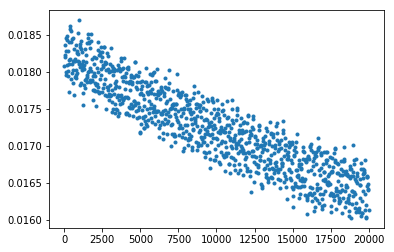

In [80]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(times, eccs, '.')

Now we try what we discussed earlier, of speeding up the eccentricity timescale and corresponding scaling the time to make the integrations run faster. I tested this thoroughly in the long runs I showed you, so I'm pretty confident this works, and is the only way we can integrate on Gyr timescales. So we decrease the eccentricity damping timescale by a factor of 100

In [81]:
sim = sa[0]
rebx = reboundx.Extras(sim)
damping = rebx.add("tides_synchronous_ecc_damping")
damping.force_as_operator = 1
damping.operator_order = 1
ps[3].params["tides_synchronous_tau_e"] = -1.e2

and now again we run for 2 eccentricity damping timescales,

In [82]:
%%time
Nout = 1000

timesfast = np.linspace(0, 2.e2, Nout)
eccsfast = np.zeros(Nout)
for i, time in enumerate(timesfast):
    sim.integrate(time)
    eccsfast[i] = ps[3].e

CPU times: user 3.83 s, sys: 15 ms, total: 3.85 s
Wall time: 3.88 s


Now we overplot our two solutions, but scale the time in our fast integration by the same factor of 100

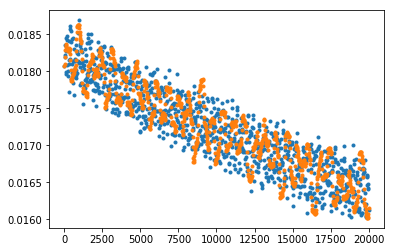

In [83]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(times, eccs, '.')
ax.plot(timesfast*100, eccsfast, '.')

You can also change the tidal damping as the simulation progresses:

In [85]:
sim = sa[0]
rebx = reboundx.Extras(sim)
damping = rebx.add("tides_synchronous_ecc_damping")
damping.force_as_operator = 1
damping.operator_order = 1

In [86]:
%%time
Nout = 1000

timesfast = np.linspace(0, 2.e2, Nout)
eccsfast = np.zeros(Nout)
for i, time in enumerate(timesfast):
    ps[3].params["tides_synchronous_tau_e"] = -1.e4/time
    sim.integrate(time)
    eccsfast[i] = ps[3].e

/mnt/raid-cita/dtamayo/j5/lib/python3.4/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


CPU times: user 3.89 s, sys: 2 ms, total: 3.89 s
Wall time: 3.91 s


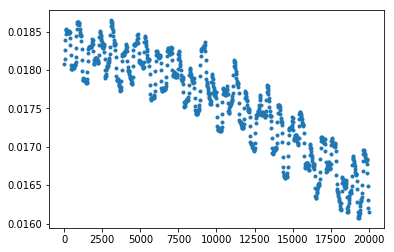

In [87]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(timesfast*100, eccsfast, '.')